# Import modules and data

In [1]:
#import libraries
%matplotlib widget
import trackpy as tp
tp.quiet()
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib as mpl
import sdt
import pickle
import scipy.io
import pims
from scipy.ndimage import gaussian_filter
import matplotlib.patches as patches
from glob import glob
import copy
from sdt import nbui, io
from sklearn.cluster import DBSCAN
import os
import re


import itertools
from matplotlib import cm
from matplotlib.colors import LightSource
from scipy.optimize import leastsq
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

In [2]:
#filter func
def filt(df, var, low, high):
    return df[(df[var]>low) & (df[var]<high)]

def poly_matrix(x, y, order=2):
    """ generate Matrix use with lstsq """
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i, j) in enumerate(ij):
        G[:, k] = x**i * y**j
    return G

# Define Gaussian function
def gauss_function(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def fit_gauss_get_values(z_hist):
    # Get the bin centers
    x_steps = z_hist[1]
    x_value = (x_steps[:-1] + x_steps[1:]) / 2  # Midpoints of histogram bins
    
    # Get the histogram values (ydata)
    ydata = z_hist[0]
    
    # Initial guess for the parameters [amplitude, mean, standard deviation]
    init_params = [np.max(ydata), np.mean(x_value), np.std(x_value)]
    
    # Perform the curve fit
    popt, pcov = curve_fit(gauss_function, x_value, ydata, p0=init_params)
    
    # popt contains the fitted parameters [A, mu, sigma]
    A, mu, sigma = popt
    A, mu, sigma = round(A, 2), round(mu, 2), round(sigma, 2)
    
    print("A exp[-0.5((x-mu)/sigma)^2]")
    print("Fit Coefficients:")
    print('A:', A, ', mu:', mu, ', sigma:', sigma)
    
    # Return the fit parameters, x values, and the fitting function for plotting
    return (popt, x_value, gauss_function)

In [3]:
# List of fibrils that should be analyzed in one ROI
List_of_fibrils = ["2_1", "2_2", "2_3", 
                   "4_1", "4_2", "4_3",
                   "5_1", "5_2"]

# List of used defocus values
List_of_def = [600, 612, 634, 650, 579, 512, 658, 586]

# List of used middle layer thicknesses
List_of_middle_layer = [243, 236, 250, 157, 138, 145, 220, 219]


List_of_val = pd.DataFrame({"fibril": List_of_fibrils,
                            "defocus": List_of_def,
                            "middle_layer": List_of_middle_layer})
List_of_val.to_csv('List_of_val.csv')

In [4]:

List_of_val = pd.read_csv('List_of_val.csv')

# Define the fibril you would like to analyze:
ROI = '2_1_2'
fibril = '5_2'
ROI_folder = f'{ROI}_fib{fibril}'
ROIdefocus = List_of_val[List_of_val['fibril']== fibril]['defocus'].iloc[0]
mid_layer = List_of_val[List_of_val['fibril']== fibril]['middle_layer'].iloc[0]

# Make a results folder
try:
    os.makedirs(f'loc_filt_GPU_results_{ROI}')
    print('new folder created')
except FileExistsError:
    print('Folder already exists')
    
# Define the directory where files are stored
directory = os.getcwd()

# Define the regex pattern
string_pattern = f'results_def_{ROIdefocus}_mid_{mid_layer}'
pattern_locs = re.compile(string_pattern)

# List all files in the directory
files = os.listdir(directory)
matching_loc_files = [f for f in files if pattern_locs.match(f)]
matching_loc_files.sort()
matching_paths = [directory+'/'+f for f in matching_loc_files]


# Use n = 1.33 for calculating the bg-tilt - correction
# n = 1.33 because the molecules on the coverslip are surrounded by buffer medium with
# a refractive index close to water (n = 1.33)
locs_using_n133 = [j for j in files if '_n1.33' in j and str(ROIdefocus) in j][0]
locs = pd.read_csv(locs_using_n133)
locs = locs.rename(columns = {'signal':'N','x':'x_res','y':'y_res'})
locs = locs.rename(columns = {'x_cor':'x','y_cor':'y'})


Folder already exists


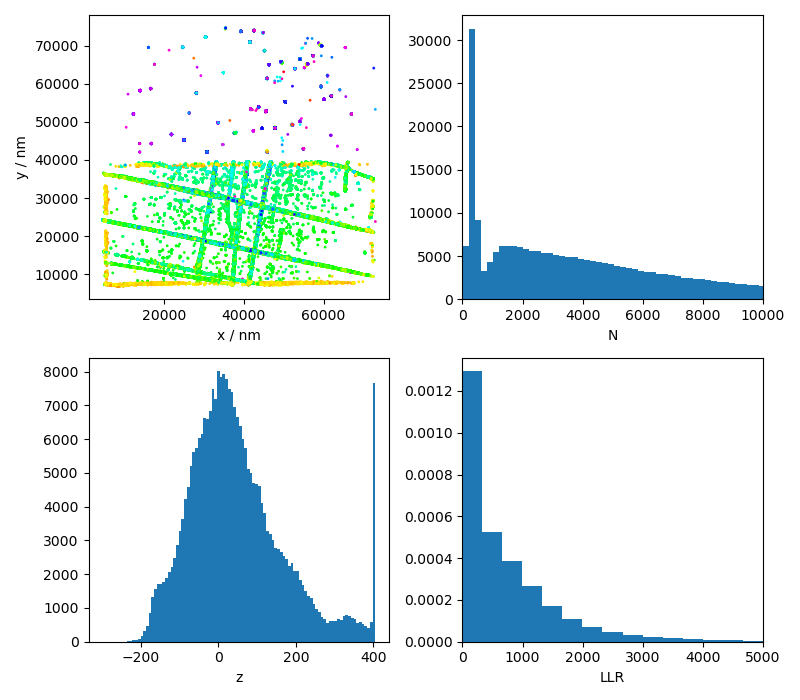

In [6]:
# Plot the localisations
fig1, ax =plt.subplots(2,2,figsize =(8,7))
a=ax[0][0].scatter(locs['x'], locs['y'], c=locs['z'], s=1, cmap='gist_rainbow')
ax[0][0].set_xlabel('x / nm')
ax[0][0].set_ylabel('y / nm')
ax[0][1].hist(locs['N'], bins=1000)
ax[0][1].set_xlabel('N'), ax[0][1].set_xlim(0,10000)
ax[1][0].hist(locs['z'], bins=100), ax[1][0].set_xlabel('z')
ax[1][1].hist(locs['LLR'], bins=1000,density=True)
ax[1][1].set_xlabel('LLR'), ax[1][1].set_xlim(0,5000)
plt.tight_layout()


In [ ]:
#filter out suspisious signals
filt_x = [20e3, 60e3]
filt_y = [9e3,38e3]
filt_N = [500, 20000]
filt_LLR = [0, 1000]

loc_filt = locs.copy()
loc_filt = filt(loc_filt, 'x', filt_x[0],filt_x[1])
loc_filt = filt(loc_filt, 'y', filt_y[0],filt_y[1])
loc_filt = filt(loc_filt, 'N', filt_N[0],filt_N[1])
loc_filt = filt(loc_filt, 'LLR', filt_LLR[0],filt_LLR[1])


fig1, ax =plt.subplots(2,2,figsize =(8,7))
a=ax[0][0].scatter(loc_filt['x'], loc_filt['y'], c=loc_filt['z'], s=1, cmap='gist_rainbow')
ax[0][0].set_xlabel('x / nm')
ax[0][0].set_ylabel('y / nm')
ax[0][0].axis('equal')
ax[0][1].hist(loc_filt['N'], bins=1000)
ax[0][1].set_xlabel('N'), ax[0][1].set_xlim(0,10000)
ax[1][0].hist(loc_filt['z'], bins=100), ax[1][0].set_xlabel('z')
ax[1][1].hist(loc_filt['LLR'], bins=1000,density=True)
ax[1][1].set_xlabel('LLR'), ax[1][1].set_xlim(0,5000)
plt.tight_layout()



# Define the tilted plane using the bg

In [1]:
# cluster the data to seperate the bg from the fibril data
# The bg is used to determine the defocus value and for the tilt correction

In [ ]:
from sklearn.cluster import DBSCAN

x = loc_filt.loc[:, ['x','y']].values
eps = 400 #300 
min_samples = 20 #100
dbscan = DBSCAN(eps = eps, min_samples = min_samples).fit(x) # fitting the model
labels = dbscan.labels_ # getting the labels
# Plot the clusters
fig, ax=plt.subplots()
plt.scatter(x[:, 0], x[:,1], c = labels, s=1) # plotting the clusters
plt.xlabel("x") # X-axis label
plt.ylabel("y") # Y-axis label
plt.show() # showing the plot

In [ ]:
loc_filt['cluster']=labels
bg_locs=loc_filt[loc_filt['cluster']<0]
col_locs=loc_filt[loc_filt['cluster']>=0]

In [ ]:
fig, ax=plt.subplots()
a=ax.scatter(col_locs['x'], col_locs['y'], c=col_locs['z'],
             s=0.1, vmin=0, vmax=600, cmap='gist_rainbow')
plt.colorbar(a, label='z / nm')
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')

In [ ]:
fig, ax=plt.subplots()
a=ax.scatter(bg_locs['x'], bg_locs['y'], c=bg_locs['z'],
             s=1, vmin=0, vmax=600, cmap='gist_rainbow')
plt.colorbar(a, label='z / nm')
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')

In [ ]:
fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(bg_locs['y'], bg_locs['z'], s=1)
ax.set_xlabel('y')
ax.set_ylabel('z')

In [ ]:
# Filter bg further
displacement=150 # default = 100
memory = 5 # default = 5

traj=tp.link(bg_locs, displacement, memory=memory, pos_columns=['x', 'y', 'z'])

In [ ]:
bg_locs_m = traj.groupby('particle').mean() # merge signals over frames
bg_locs_m['len']=traj.groupby('particle').apply(len) # how many frames does the signal prevail

fig,ax = plt.subplots()
ax.scatter(bg_locs_m['len'],bg_locs_m['z'],s=1)
ax.plot([1.5,1.5],[-100,100],label='cutoff at len > 1',c='r')
ax.set_xlabel('len of traj')
ax.set_ylabel('z / nm')
ax.legend()

In [ ]:
# Calculate the std of the z positions:
mean_z_bg = np.median(bg_locs_m['z'])
std_z_bg = 2*np.std(bg_locs_m['z'])


fig,ax = plt.subplots()
ax.hist(bg_locs_m['z'],bins=50)
ax.plot([mean_z_bg-std_z_bg,mean_z_bg-std_z_bg],[0,100],color = 'r')
ax.plot([mean_z_bg+std_z_bg,mean_z_bg+std_z_bg],[0,100],color = 'r')
ax.set_xlabel('z')

In [ ]:
fig,ax = plt.subplots()
ax.scatter(bg_locs_m['N'],bg_locs_m['z'],s=0.1)
ax.set_xlabel('Photon number N')
# ax.plot([500,500],[-100,100],color = 'red',label = ' cutoff at N = 500')
ax.plot([8000,8000],[-100,100],color = 'red',label = ' cutoff at N = 8000')
ax.legend()
ax.set_ylabel('z')

In [ ]:
fig,ax = plt.subplots()
# ax.hist(bg_locs_m['LLR'],bins=50)

ax.scatter(bg_locs_m['LLR'],bg_locs_m['z'],s=0.1)
ax.set_xlabel('LLR')
ax.plot([np.median(bg_locs_m['LLR']),np.median(bg_locs_m['LLR'])],
        [-100,100],color = 'black',label = 'median LLR')
ax.plot([300,300],[-100,100],color = 'red',label = ' cutoff at LLR = 300')
ax.legend()
ax.set_ylabel('z')

In [ ]:
# refine the filtration step for the localisations

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(bg_locs_m['y'], bg_locs_m['z'], s=1,label='before filtration')
ax.scatter(bg_locs_m[bg_locs_m['len']>1]['y'], 
           bg_locs_m[bg_locs_m['len']>1]['z'], 
           s=2,color = 'r',label='only len>1')
ax.legend()

In [ ]:
# refine the filtration step for the localisations

bg_locs_m = bg_locs_m[bg_locs_m['len']>1]
bg_locs_m = filt(bg_locs_m,'N',0,8000)
bg_locs_m = bg_locs_m[bg_locs_m['LLR']<250]
bg_locs_m = filt(bg_locs_m,'z',mean_z_bg-std_z_bg,mean_z_bg+std_z_bg)

fig = plt.figure()
ax = fig.add_subplot()
ax.scatter(bg_locs['y'], bg_locs['z'], s=1,label = 'before filtration',c='C0')
ax.scatter(bg_locs_m['y'], bg_locs_m['z'], s=1,label='after filtration',c='r')
ax.legend()

In [ ]:


import itertools
from matplotlib import cm
from matplotlib.colors import LightSource


def poly_matrix(x, y, order=2):
    """ generate Matrix use with lstsq """
    ncols = (order + 1)**2
    G = np.zeros((x.size, ncols))
    ij = itertools.product(range(order+1), range(order+1))
    for k, (i, j) in enumerate(ij):
        G[:, k] = x**i * y**j
    return G



points = np.array(bg_locs_m[['x', 'y', 'z']])
ordr = 1  # order of polynomial
x, y, z = points.T
#x, y = x - x[0], y - y[0]  # this improves accuracy

# make Matrix:
G = poly_matrix(x, y, ordr)
# Solve for np.dot(G, m) = z:
m = np.linalg.lstsq(G, z)[0]
curv=m

GGG = poly_matrix(np.array(bg_locs_m['x']), np.array(bg_locs_m['y']), ordr)
zzz=np.dot(GGG, curv)
bg_locs_m['z_cor'] = bg_locs_m['z']-zzz# + m[0]

In [54]:
# Create a 3D plot for the original surface

# Create meshgrid for fitted surface
x_min, x_max = np.min(bg_locs_m['x']), np.max(bg_locs_m['x'])
y_min, y_max = np.min(bg_locs_m['y']), np.max(bg_locs_m['y'])
x_grid, y_grid = np.meshgrid(np.linspace(x_min, x_max, 1000), np.linspace(y_min, y_max, 1000))
G_grid = poly_matrix(x_grid.ravel(), y_grid.ravel(), ordr)
z_fit = np.dot(G_grid, curv).reshape(x_grid.shape)

In [55]:
df_fitted_surface = pd.DataFrame({
    'x': x_grid.ravel(),
    'y': y_grid.ravel(),
    'z': z_fit.ravel()})

# fig = plt.figure(figsize=(8, 8))
# ax1 = fig.add_subplot(projection='3d')
# ax1.scatter(df_fitted_surface['x'], df_fitted_surface['y'], df_fitted_surface['z'])

In [56]:
df_fitted_surface.to_csv(f'df_fitted_surface_def{ROIdefocus}_fibril_{fibril}.csv')

In [57]:
np.median(df_fitted_surface['z'])

# The median should be around 0, 
# to find the true defocus of that individual fibril

4.637511356494947

# Selecting the individual fibrils 

## Select fibrils using the cutout parameters

In [ ]:
# the fibrils are seperated from the bg 
# by selecting them with a polygonal "cutting" algorithm

# The cutouts parameters are svaed in the fibril_cutouts.pkl file
# If there are no cutout parameters defined a new cutout has to be made

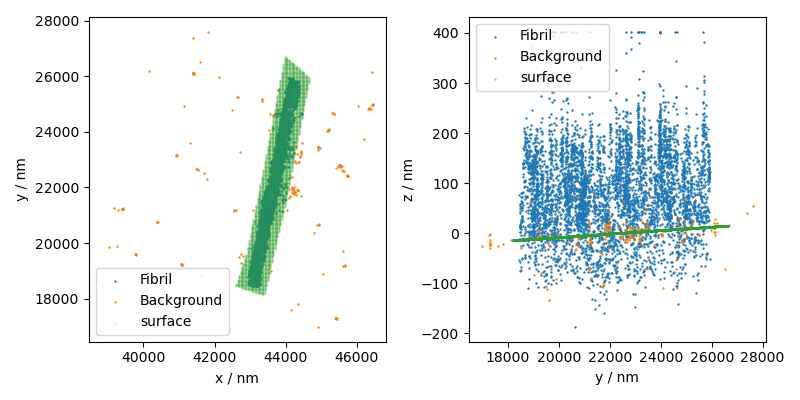

In [58]:

    
# Load cutout coordinates
with open('fibril_cutouts.pkl', 'rb') as file:
    fibril_cutouts = pickle.load(file)

# Remove duplicate rows based on all columns
# fibril_cutouts = fibril_cutouts.drop_duplicates()

# Check if the specified ROI and fibril exist in the data
if ROI in fibril_cutouts['ROI'].values:
    sublist = fibril_cutouts[fibril_cutouts['ROI'] == ROI]
    
    if fibril in sublist['fibril'].values:
        selected_fibril_cutout = sublist[sublist['fibril'] == fibril].iloc[0]
        
        # Extract paths for fibril and background
        path_fib = selected_fibril_cutout['path_fib']
        path_bg = selected_fibril_cutout['path_bg']

        # Background locations
        bg_coords = np.column_stack([locs['x'], locs['y']])
        S_selected_bg = path_bg.contains_points(bg_coords)
        bg = locs[S_selected_bg]

        # Fibril locations
        locf_coords = np.column_stack([bg['x'], bg['y']])
        S_selected_fib = path_fib.contains_points(locf_coords)
        locf = bg[S_selected_fib]

        # Separate the background from the fibril locations
        bg_locs = bg[~bg['x'].isin(locf['x'])]
        
        # Surface locations
        df_surface = df_fitted_surface.copy()
        surface_coords = np.column_stack([df_surface['x'], df_surface['y']])
        Surface_selected_fib = path_fib.contains_points(surface_coords)
        surface = df_surface[Surface_selected_fib]
        
        # Plot the cutout results
        fig, ax = plt.subplots(1, 2, figsize=(8, 4))
     
        ax[0].scatter(locf['x'], locf['y'], s=0.5, label="Fibril")
        ax[0].scatter(bg_locs['x'], bg_locs['y'],s=0.5, label="Background")
        ax[0].scatter(surface['x'],surface['y'], s=.1,alpha=0.5, label='surface')
        ax[0].set_xlabel('x / nm')
        ax[0].set_ylabel('y / nm')
        ax[0].legend()

     
        ax[1].scatter(locf['y'], locf['z'], s=0.5, label="Fibril")
        ax[1].scatter(bg_locs['y'], bg_locs['z'],s=0.5,  label="Background")
        ax[1].scatter(surface['y'],surface['z'], s=.1,label='surface')
        ax[1].set_xlabel('y / nm')
        ax[1].set_ylabel('z / nm')
        ax[1].legend()
        
       
        plt.tight_layout()
        
    else:
        print(f'Fibril {fibril} not found in ROI {ROI}.')
else:
    print('Please make a new cutout.')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


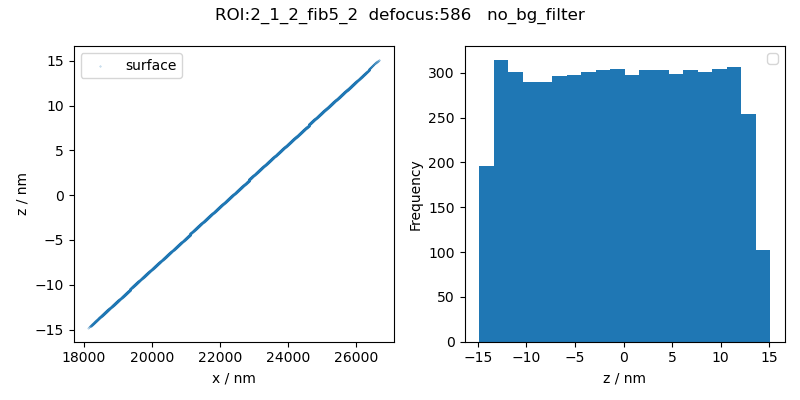

In [59]:


# Plot the cutout results
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].scatter(surface['y'],surface['z'], s=.1,alpha=0.5, label='surface')
ax[0].set_xlabel('x / nm')
ax[0].set_ylabel('z / nm')
ax[0].legend()
fig.suptitle(f'ROI:{ROI_folder}  defocus:{ROIdefocus}   no_bg_filter')

# Histogram and Gaussian fit
h1 = ax[1].hist(surface['z'],bins=20)
ax[1].legend()
ax[1].set_xlabel('z / nm')
ax[1].set_xlabel('z / nm')
ax[1].set_ylabel('Frequency')
plt.tight_layout()
plt.show()
# fig.savefig(find_def_folder+f'/hist_bg_locs_no_filt_{ROI_folder}_{ROIdefocus}.png',dpi=500)


## Alternatively: Make a new fibril cutout

In [60]:
fibril_cutouts 

,ROI,fibril,path_fib,path_bg
0,2_1_2,4_1,"Path(array([[37340.40454455, 15576.68582521],\...","Path(array([[33400.11623276, 17041.90564862],\..."
1,2_1_2,4_2,"Path(array([[38783.87281767, 26646.64203829],\...","Path(array([[36714.78717632, 28917.04037642],\..."
2,2_1_2,2_1,"Path(array([[24502.78924036, 20635.03603753],\...","Path(array([[25352.5341027 , 23314.48204034],\..."
3,2_1_2,2_2,"Path(array([[30974.49411759, 19524.99318274],\...","Path(array([[30687.13225012, 19525.3609154 ],\..."
4,2_1_2,2_3,"Path(array([[43954.78900016, 16142.16280104],\...","Path(array([[43394.20413776, 14839.29764674],\..."
5,2_1_2,5_1,"Path(array([[42036.32403865, 14941.69241073],\...","Path(array([[38847.31349445, 16091.33902882],\..."
6,2_1_2,5_2,"Path(array([[43973.4179802 , 26743.35186676],\...","Path(array([[40207.28184677, 28070.76094922],\..."
7,2_1_2,4_3,"Path(array([[40210.799919 , 37718.0943921 ],\...","Path(array([[38556.70723586, 37317.46760738],\..."


Text(0, 0.5, 'y / nm')

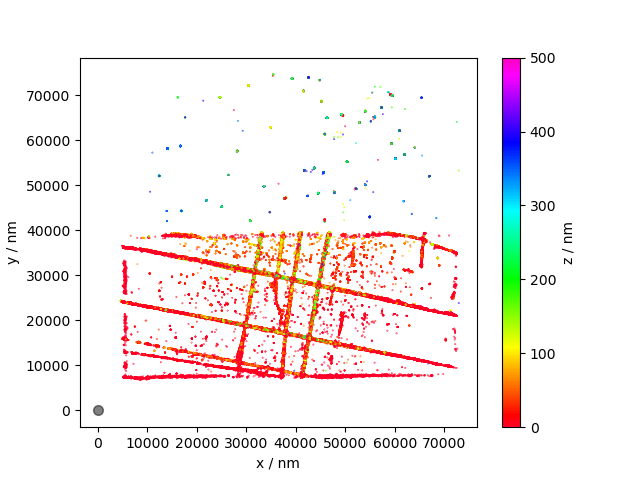

In [61]:
# plot first results
fig, ax=plt.subplots()
a=ax.scatter(locs['x'], locs['y'], c=locs['z'], 
             s=0.1, vmin=0, vmax=500, cmap='gist_rainbow')
plt.colorbar(a, label='z / nm',ax=ax)
sel_bg = mpl.widgets.PolygonSelector(ax, lambda x: None)  # for Rectangle Ellipse: interactive=True)
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')

In [62]:
path_bg = mpl.path.Path(sel_bg.verts)

# STORM fibril
bg = np.column_stack([locs['x'], locs['y']]) #scatter_pos
S_selected_bg = path_bg.contains_points(bg)
bg = locs[S_selected_bg]

# plot first results
fig, ax=plt.subplots()
a=ax.scatter(bg['x'], bg['y'], c=bg['z'], 
             s=0.1, cmap='gist_rainbow')
sel_fib = mpl.widgets.PolygonSelector(ax, lambda x: None)
plt.colorbar(a, label='z / nm',ax=ax)
ax.set_xlabel('x / nm')
ax.set_ylabel('y / nm')
ax.set_xlim(min(bg['x'])-300,max(bg['x'])+300)
ax.set_ylim(min(bg['y'])-300,max(bg['y'])+300)

ValueError: 'vertices' must be 2D with shape (M, 2). Your input has shape (0,).

In [ ]:
path_fib = mpl.path.Path(sel_fib.verts)

# STORM fibril
locf = np.column_stack([bg['x'], bg['y']]) #scatter_pos
S_selected_fib = path_fib.contains_points(locf)
locf = bg[S_selected_fib]

# Separate the bg from the locs:
bg_locs = bg[~bg['x'].isin(locf['x'])]

# plot cutout results
fig, ax=plt.subplots(1,2,figsize = (8,4))
ax[0].scatter(bg_locs['x'], bg_locs['y'], s=1)
ax[0].scatter(locf['x'], locf['y'], s=0.1)
ax[0].set_xlabel('x / nm')
ax[0].set_ylabel('y / nm')

ax[1].scatter(bg_locs['y'], bg_locs['z'], s=1)
ax[1].scatter(locf['y'], locf['z'], s=0.1)
ax[1].set_xlabel('y / nm')
ax[1].set_ylabel('z / nm')

In [ ]:

if ROI in fibril_cutouts['ROI'].values:
    sublist = fibril_cutouts[fibril_cutouts['ROI'] == ROI]
    
    if fibril in sublist['fibril'].values:
    # Check if the specified ROI and fibril exist in the data

        Q1 = input(f'Do you want to override the old cutout coordinates for fibril {fibril}? (y/n): ')
        if Q1 == 'y':
            # Update the coordinates for the existing entry
            fibril_cutouts.loc[(fibril_cutouts['ROI'] == ROI) & (fibril_cutouts['fibril'] == fibril),
                               ['path_fib', 'path_bg']] = [path_fib, path_bg]

            # Save the updated DataFrame
            with open('fibril_cutouts.pkl', 'wb') as file:
                pickle.dump(fibril_cutouts, file)
        else:
            print("Keeping existing cutout coordinates.")
    else:
        # Save the new cutout coordinates
        new_line = pd.DataFrame({'ROI':[ROI],'fibril':[fibril],
                                     'path_fib':[path_fib],'path_bg':[path_bg]})
        fibril_cutouts = pd.concat([fibril_cutouts, new_line], ignore_index=True)

        with open(f'fibril_cutouts.pkl', 'wb') as file:
            pickle.dump(fibril_cutouts,file)
else:
    # Save the new cutout coordinates
    new_line = pd.DataFrame({'ROI':[ROI],'fibril':[fibril],
                                 'path_fib':[path_fib],'path_bg':[path_bg]})
    fibril_cutouts = pd.concat([fibril_cutouts, new_line], ignore_index=True)
    
    with open(f'fibril_cutouts.pkl', 'wb') as file:
        pickle.dump(fibril_cutouts,file)

# Tilt correction

In [63]:
# Make a new folder for a specific fibril
fibril_folder = f'loc_filt_GPU_results_{ROI}/fibril_{fibril}'

try:
    os.makedirs(fibril_folder)
    print('new folder created')
except FileExistsError:
    print('Folder already exists')

tilt_res_folder = fibril_folder+'/tilt_correction'
try:
    os.makedirs(tilt_res_folder)
    print('new folder created')
except FileExistsError:
    print('Folder already exists')
    
# Create a saving_label
Label = f'ROI_{ROI}_fibril_{fibril}_{ROIdefocus}'

new folder created
new folder created


In [64]:
# Calc loc precision:
displacement = 150 # default = 100
memory = 5 # default = 5

traj=tp.link(locf, displacement, memory=memory, pos_columns=['x', 'y'])
m_locs=traj.groupby('particle').mean() # merge signals over frames
m_locs['len']=traj.groupby('particle').apply(len) 
# how many frames does the signal prevail


# loc precision
# standard deviation of the particle movement
# this gives the localisation precision in each direction respectively
m_locs['stdx']=traj['x'].groupby(traj['particle']).apply(np.std) 
m_locs['stdy']=traj['y'].groupby(traj['particle']).apply(np.std)
m_locs['stdz']=traj['z'].groupby(traj['particle']).apply(np.std)

# mean of the standard deviations of the movements
dx_loc=round(np.mean(m_locs['stdx'][m_locs['len']>1]),2) 
dy_loc=round(np.mean(m_locs['stdy'][m_locs['len']>1]),2)
dz_loc=round(np.mean(m_locs['stdz'][m_locs['len']>1]),2)

N_mean = round(np.mean(locf['N']),2)
bg_mean = round(np.mean(locf['bg']),2)

info_box = [f'curvature correcting polynome order =  {ordr}',
         f'displacement = {displacement}',f'memory = {memory}',
         f'N_mean = {N_mean}',f'bg_mean = {bg_mean}',
         f'dx_loc = {dx_loc}',f'dy_loc = {dy_loc}',f'dz_loc = {dz_loc}']
# save info
with open(f'loc_filt_GPU_results_{ROI}/fibril_{fibril}/info_'+Label+'.yaml', "w") as f:
    sdt.io.yaml.safe_dump(info_box, f)

    # load info
with open(f'loc_filt_GPU_results_{ROI}/fibril_{fibril}/info_'+Label+'.yaml', "r") as f:
    info_box = sdt.io.yaml.safe_load(f)
    

In [65]:
matching_paths

['/Users/simonjaritz/Desktop/bg analysis/2_1_2/results_def_586_mid_219_n133_n1.33_n1518.csv',
 '/Users/simonjaritz/Desktop/bg analysis/2_1_2/results_def_586_mid_219_n133_n1.38_n1518.csv',
 '/Users/simonjaritz/Desktop/bg analysis/2_1_2/results_def_586_mid_219_n133_n1.42_n1518.csv',
 '/Users/simonjaritz/Desktop/bg analysis/2_1_2/results_def_586_mid_219_n133_n1.44_n1518.csv',
 '/Users/simonjaritz/Desktop/bg analysis/2_1_2/results_def_586_mid_219_n133_n1.46_n1518.csv',
 '/Users/simonjaritz/Desktop/bg analysis/2_1_2/results_def_586_mid_219_n133_n1.48_n1518.csv',
 '/Users/simonjaritz/Desktop/bg analysis/2_1_2/results_def_586_mid_219_n133_n1.4_n1518.csv',
 '/Users/simonjaritz/Desktop/bg analysis/2_1_2/results_def_586_mid_219_n133_n1.518_n1518.csv']

0 % of the analysis done


/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_24692/3769700420.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locfi['z_cor']=locfi['z']#-zzz# + m[0]


12 % of the analysis done


/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_24692/3769700420.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locfi['z_cor']=locfi['z']#-zzz# + m[0]


25 % of the analysis done


/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_24692/3769700420.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locfi['z_cor']=locfi['z']#-zzz# + m[0]
/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_24692/3769700420.py:103: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig4,ax = plt.subplots()


37 % of the analysis done


/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_24692/3769700420.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locfi['z_cor']=locfi['z']#-zzz# + m[0]


50 % of the analysis done


/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_24692/3769700420.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locfi['z_cor']=locfi['z']#-zzz# + m[0]


62 % of the analysis done


/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_24692/3769700420.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locfi['z_cor']=locfi['z']#-zzz# + m[0]


75 % of the analysis done


/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_24692/3769700420.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locfi['z_cor']=locfi['z']#-zzz# + m[0]


87 % of the analysis done


/var/folders/6w/pbgpd7kd1g75lqfyc3cb5ny40000gn/T/ipykernel_24692/3769700420.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  locfi['z_cor']=locfi['z']#-zzz# + m[0]


script is ready


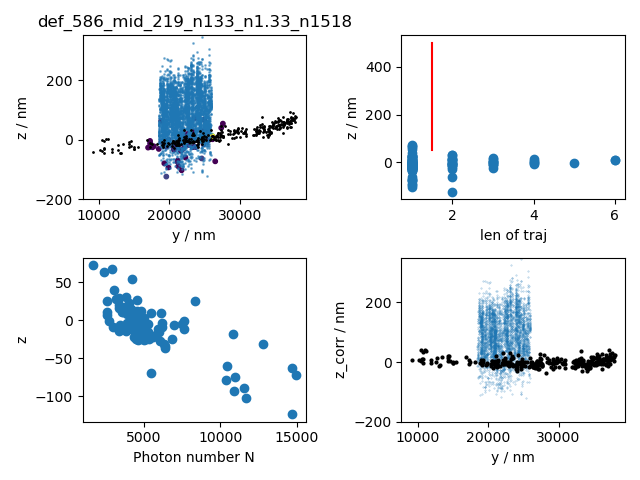

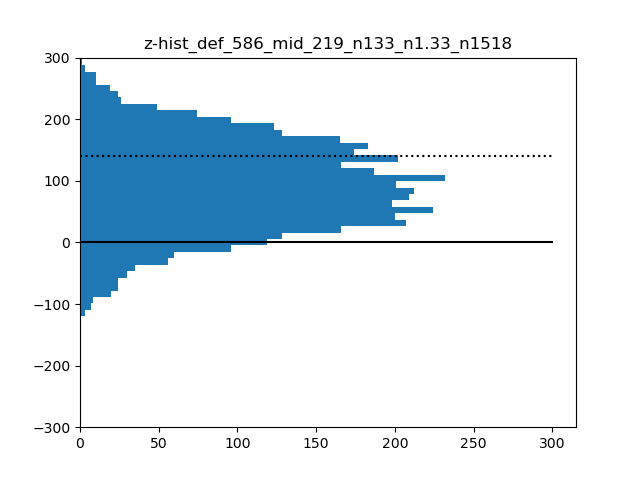

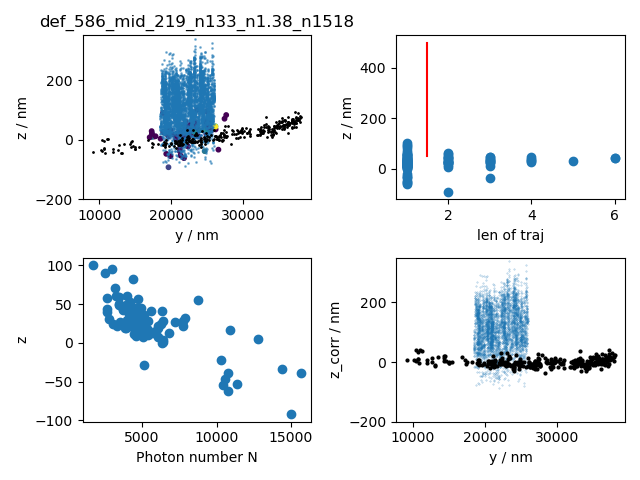

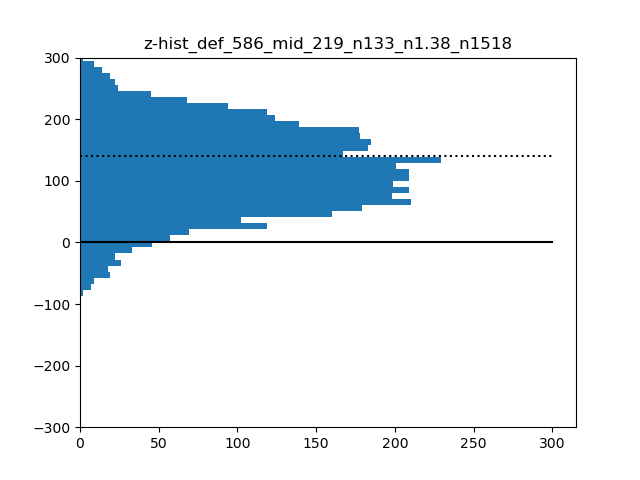

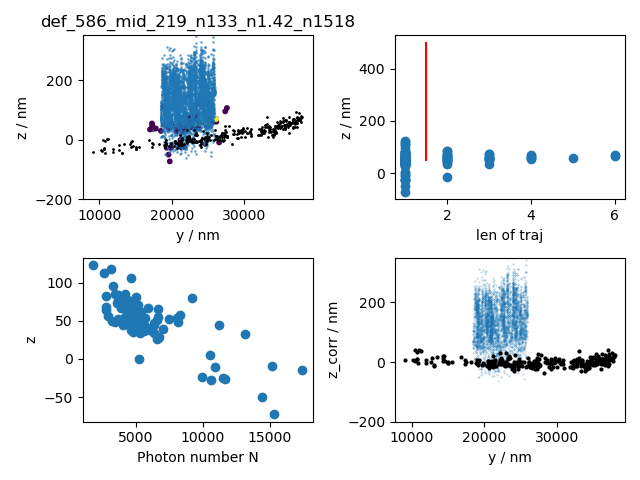

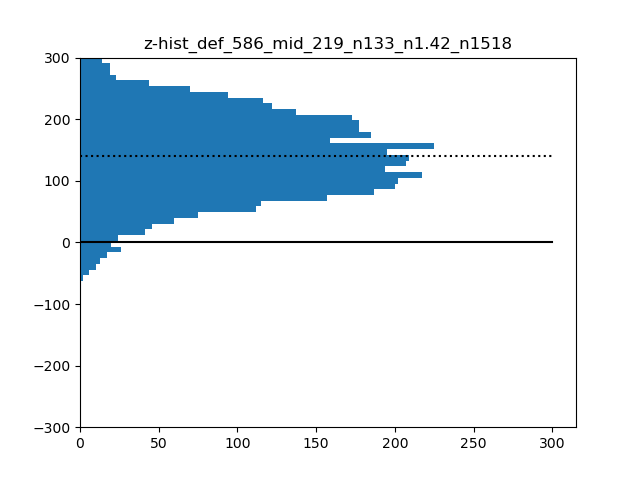

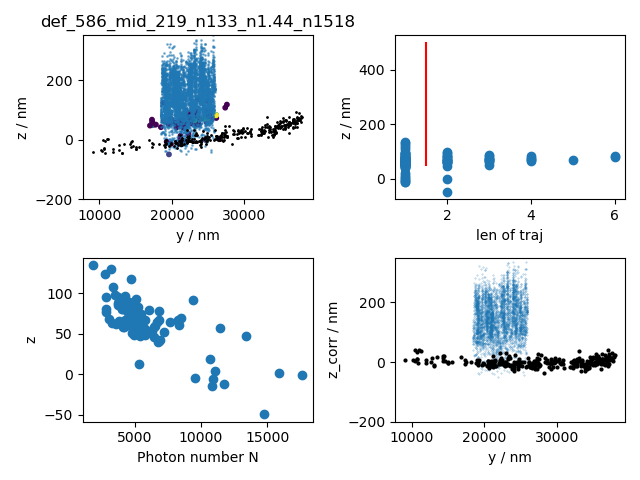

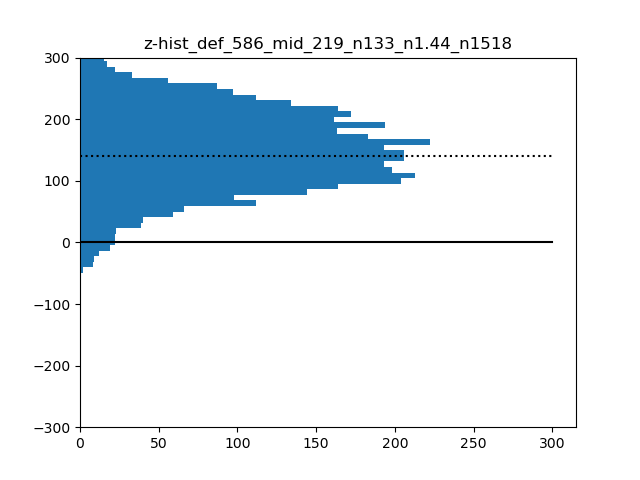

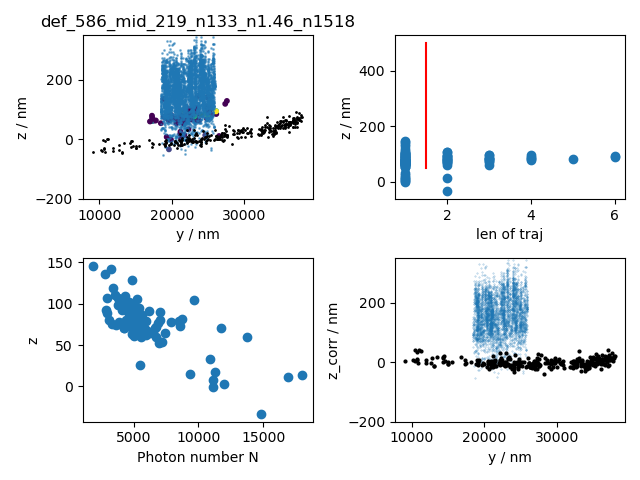

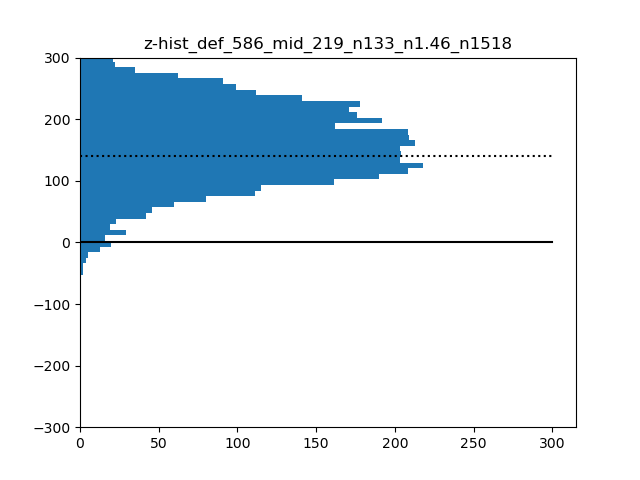

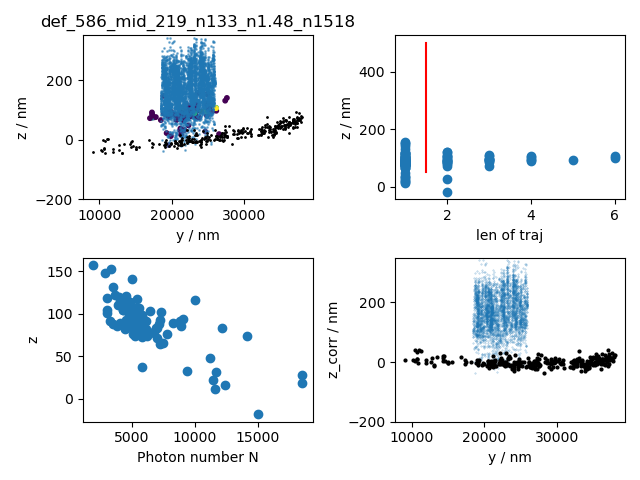

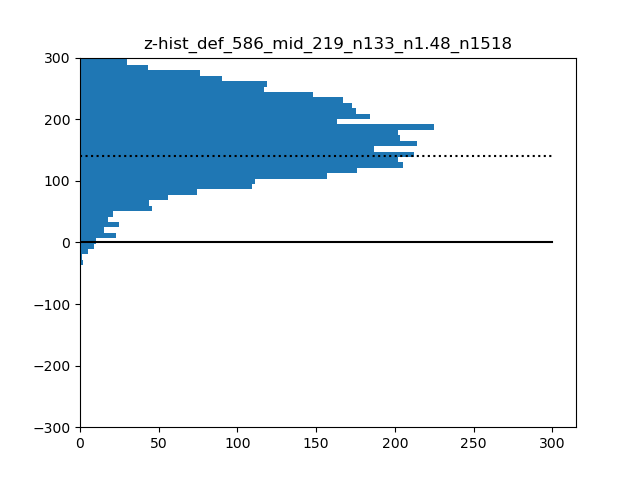

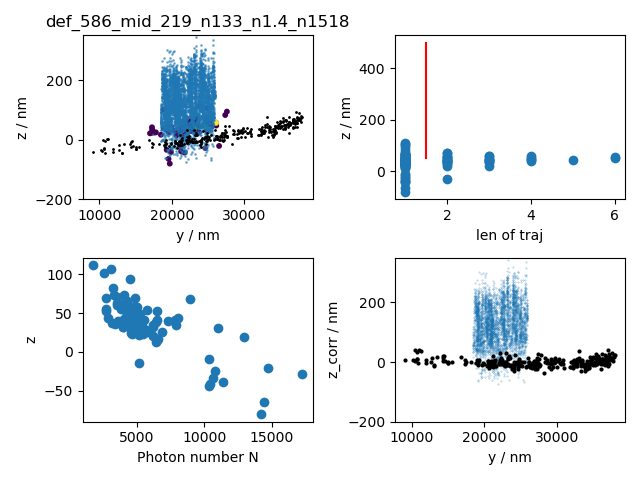

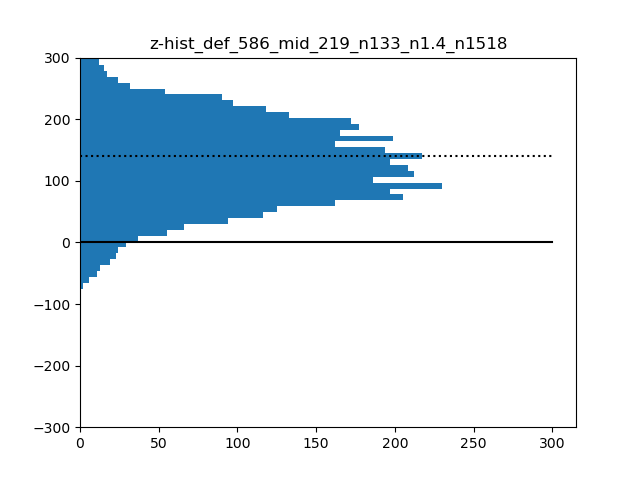

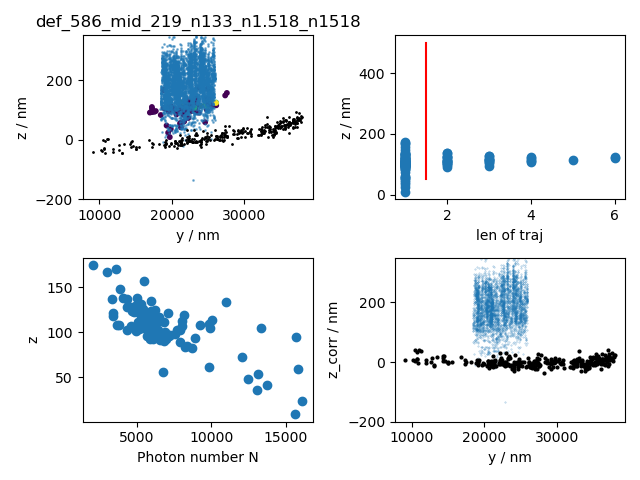

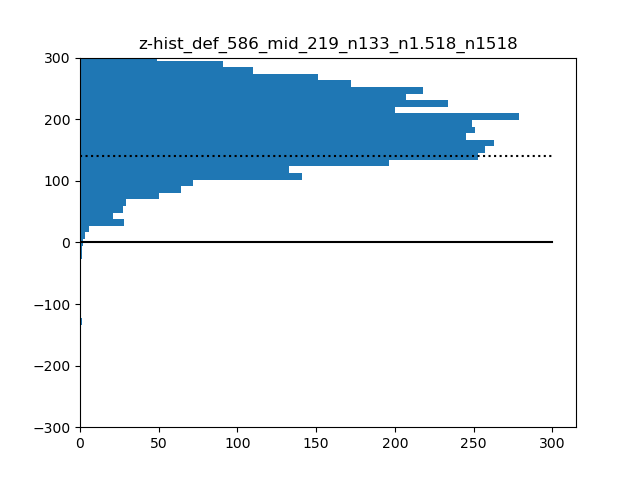

In [66]:

locs_using_def = matching_paths
result_df = pd.DataFrame(columns=['ROI','fibril','defocus','bg_locsi_m','locfi'])

# Start of the loop
for k in range(len(locs_using_def)):
    print(int(k/len(locs_using_def)*100),'% of the analysis done')
    current_defocus = locs_using_def[k]
    defocus = current_defocus.split('/results_')[1][:-4]
    
    # Create a saving_label
    Label = f'ROI_{ROI}_fibril_{fibril}_{defocus}'
    
    # Load one dataset:
    locsi = pd.read_csv(current_defocus)
    locsi = locsi.rename(columns = {'signal':'N','x':'x_res','y':'y_res'})
    locsi = locsi.rename(columns = {'x_cor':'x','y_cor':'y'})
    
    
#     Filter it like the example in the beginning
    locsi = filt(locsi, 'x', filt_x[0],filt_x[1])
    locsi = filt(locsi, 'y', filt_y[0],filt_y[1])
    locsi = filt(locsi, 'N', filt_N[0],filt_N[1])
    locsi = filt(locsi, 'LLR', filt_LLR[0],filt_LLR[1])
    

    # STORM fibril
    bgi = np.column_stack([locsi['x'], locsi['y']])
    S_selected_bgi = path_bg.contains_points(bgi)
    bgi = locsi[S_selected_bgi]

    # STORM fibril
    locfi = np.column_stack([bgi['x'], bgi['y']])
    S_selected_fib = path_fib.contains_points(locfi)
    locfi = bgi[S_selected_fib]

    # Separate the bg from the locsi:
    bg_locsi = bgi[~bgi['x'].isin(locfi['x'])]




    ######## bg filtration
    ## --> refinement step
    displacement = 150 # default = 100
    memory = 5 # default = 5
    traj=tp.link(bg_locsi, displacement, memory=memory, pos_columns=['x', 'y'])
    bg_locsi_m = traj.groupby('particle').mean() # merge signals over frames
    bg_locsi_m['len']=traj.groupby('particle').apply(len) 
    # how many frames does the signal prevail

    fig3,ax = plt.subplots(2,2)
    ax[0][0].set_title(f'{defocus}')
    ax[0][0].scatter(bg_locsi_m['y'], bg_locsi_m['z'],c = bg_locsi_m['len'], s=10)
    ax[0][0].scatter(locfi['y'], locfi['z'], s=1,alpha = 0.5)
    ax[0][0].set_xlabel('y / nm')
    ax[0][0].set_ylabel('z / nm')

    ax[0][1].scatter(bg_locsi_m['len'],bg_locsi_m['z'])
    ax[0][1].plot([1.5,1.5],[50,500],label='cutoff at len > 1',c='r')
    ax[0][1].set_xlabel('len of traj')
    ax[0][1].set_ylabel('z / nm')

    ax[1][0].scatter(bg_locsi_m['N'],bg_locsi_m['z'])
    ax[1][0].set_xlabel('Photon number N')
    ax[1][0].set_ylabel('z')
  
        
    # Continue with refining:
    # refine the filtration step for the bg localisations
    bg_locsi_m = bg_locsi_m[bg_locsi_m['len']>1]

    
    GGG = poly_matrix(np.array(bg_locsi_m['x']), np.array(bg_locsi_m['y']), ordr)
    zzz = np.dot(GGG, curv)
    bg_locsi_m['z_cor'] = bg_locsi_m['z']#-zzz# + m[0]

    ##### correct collagen curvature
    GGG = poly_matrix(np.array(locfi['x']), np.array(locfi['y']), ordr)
    zzz=np.dot(GGG, curv)
    locfi['z_cor']=locfi['z']#-zzz# + m[0]
    
    
#     ax[1][1].scatter(bg_locsi_m['y'], bg_locsi_m['z'], s=1)
    ax[1][1].set_xlabel('y / nm')
    ax[1][1].set_ylabel('z_corr / nm')
    ax[1][1].scatter(locfi['y'], locfi['z_cor'], s=0.1,alpha=0.5)
    ax[0][0].scatter(bg_locs_m['y'], bg_locs_m['z'],c = 'k', s=1)
    ax[1][1].scatter(bg_locs_m['y'], bg_locs_m['z_cor'], c='k',s=4)
    ax[0][0].set_ylim(-200,350)
    ax[1][1].set_ylim(-200,350)
    plt.tight_layout()
    

    fig3.savefig(tilt_res_folder+f'/overview_bg_correction_{Label}.png',dpi=600)
     
        
    fig4,ax = plt.subplots()
    ax.set_title(f'z-hist_{defocus}')
    ax.hist(locfi['z'],bins=50,orientation='horizontal')
    ax.plot([0,300],[0,0],c='k')
    ax.plot([0,300],[140,140],c='k',linestyle=':')
    ax.set_ylim(-300,300)
    fig4.savefig(tilt_res_folder+f'/histogram_z_locs_{Label}.png',dpi=600)
    
    
    # Save the results
    new_df = {'ROI':ROI,
              'fibril':fibril,
              'defocus':defocus,
              'bg_locsi_m':bg_locsi_m,
              'locfi':locfi}
    result_df.loc[len(result_df)] = new_df 
    # save the filtered localisations:
    locfi.to_csv(tilt_res_folder+f'/STORM_localisations_filtered_'+Label+'.csv')
    bg_locsi_m.to_csv(tilt_res_folder+f'/STORM_bg_localisations_filtered_'+Label+'.csv')
    
print('script is ready')

In [67]:
result_df

,ROI,fibril,defocus,bg_locsi_m,locfi
0,2_1_2,5_2,def_586_mid_219_n133_n1.33_n1518,Unnamed: 0 id ...,Unnamed: 0 id frame x_re...
1,2_1_2,5_2,def_586_mid_219_n133_n1.38_n1518,Unnamed: 0 id ...,Unnamed: 0 id frame x_re...
2,2_1_2,5_2,def_586_mid_219_n133_n1.42_n1518,Unnamed: 0 id ...,Unnamed: 0 id frame x_re...
3,2_1_2,5_2,def_586_mid_219_n133_n1.44_n1518,Unnamed: 0 id ...,Unnamed: 0 id frame x_re...
4,2_1_2,5_2,def_586_mid_219_n133_n1.46_n1518,Unnamed: 0 id ...,Unnamed: 0 id frame x_re...
5,2_1_2,5_2,def_586_mid_219_n133_n1.48_n1518,Unnamed: 0 id ...,Unnamed: 0 id frame x_re...
6,2_1_2,5_2,def_586_mid_219_n133_n1.4_n1518,Unnamed: 0 id ...,Unnamed: 0 id frame x_re...
7,2_1_2,5_2,def_586_mid_219_n133_n1.518_n1518,Unnamed: 0 id ...,Unnamed: 0 id frame x_re...


In [ ]:

df133 = result_df[result_df['defocus']==f'def_{ROIdefocus}_n133_n1.33_n1518']['locfi'].iloc[0]
df133_bg = result_df[result_df['defocus']==f'def_{ROIdefocus}_n133_n1.33_n1518']['bg_locsi_m'].iloc[0]
df140 = result_df[result_df['defocus']==f'def_{ROIdefocus}_n133_n1.4_n1518']['locfi'].iloc[0]
df140_bg = result_df[result_df['defocus']==f'def_{ROIdefocus}_n133_n1.4_n1518']['bg_locsi_m'].iloc[0]
df145 = result_df[result_df['defocus']==f'def_{ROIdefocus}_n133_n1.46_n1518']['locfi'].iloc[0]
df145_bg = result_df[result_df['defocus']==f'def_{ROIdefocus}_n133_n1.46_n1518']['bg_locsi_m'].iloc[0]
df152 = result_df[result_df['defocus']==f'def_{ROIdefocus}_n133_n1.518_n1518']['locfi'].iloc[0]
df152_bg = result_df[result_df['defocus']==f'def_{ROIdefocus}_n133_n1.518_n1518']['bg_locsi_m'].iloc[0]


fig,ax = plt.subplots(2,2,figsize=(8,8))
ax[0][0].scatter(df133['y'],df133['z'],s=0.1,alpha=0.5,c='C0',label='collagen locs')
ax[0][0].scatter(df133_bg['y'],df133_bg['z'],s=1,alpha=1,c='C1',label='bg locs')
ax[0][0].set_title(f'A - def_{ROIdefocus}_n133_n1.33_n1518\nwith middle layer')

ax[0][0].set_xlabel('y / nm')
ax[0][0].set_ylabel('z / nm')
ax[0][0].axhline(0, color='grey', linestyle='-',alpha=0.2)
ax[0][0].axhline(140, color='grey',alpha=0.5,linestyle=':',label='AFM_height')

# ax[0][0].set_xlim(18e3,28e3)
# ax[0][0].set_ylim(-200,300)
ax[0][0].legend()
ax[0][0].grid(color='lightgrey',alpha=0.3)

ax[0][1].scatter(df140['y'],df140['z'],s=0.1,alpha=0.5,c='C0',label='collagen locs')
ax[0][1].scatter(df140_bg['y'],df140_bg['z'],s=1,alpha=1,c='C1',label='bg locs')
ax[0][1].set_title(f'B - def_{ROIdefocus}_n133_n1.40_n1518\nwith middle layer')

ax[0][1].set_xlabel('y / nm')
ax[0][1].set_ylabel('z / nm')
ax[0][1].axhline(0, color='grey', linestyle='-',alpha=0.2)
ax[0][1].axhline(140, color='grey',alpha=0.5,linestyle=':',label='AFM_height')
# ax[0][1].set_xlim(18e3,28e3)
# ax[0][1].set_ylim(-200,300)
ax[0][1].legend()
ax[0][1].grid(color='lightgrey',alpha=0.3)

ax[1][0].scatter(df145['y'],df145['z'],s=0.1,alpha=0.5,c='C0',label='collagen locs')
ax[1][0].scatter(df145_bg['y'],df145_bg['z'],s=1,alpha=1,c='C1',label='bg locs')
ax[1][0].set_title(f'C - def_{ROIdefocus}_n133_n1.46_n1518\nwith middle layer')

ax[1][0].set_xlabel('y / nm')
ax[1][0].set_ylabel('z / nm')
ax[1][0].axhline(0, color='grey', linestyle='-',alpha=0.2)
ax[1][0].axhline(140, color='grey',alpha=0.5,linestyle=':',label='AFM_height')
# ax[1][0].set_xlim(18e3,28e3)
# ax[1][0].set_ylim(-200,300)
ax[1][0].legend()
ax[1][0].grid(color='lightgrey',alpha=0.3)

ax[1][1].scatter(df152['y'],df152['z'],s=0.1,alpha=0.5,c='C0',label='collagen locs')
ax[1][1].scatter(df152_bg['y'],df152_bg['z'],s=1,alpha=1,c='C1',label='bg locs')
ax[1][1].set_title(f'D - def_{ROIdefocus}_n133_n1518_n1518\nwith middle layer')

ax[1][1].set_xlabel('y / nm')
ax[1][1].set_ylabel('z / nm')
ax[1][1].axhline(0, color='grey', linestyle='-',alpha=0.2)
ax[1][1].axhline(140, color='grey',alpha=0.5,linestyle=':',label='AFM_height')
# ax[1][1].set_xlim(18e3,28e3)
# ax[1][1].set_ylim(-200,300)
ax[1][1].legend()
ax[1][1].grid(color='lightgrey',alpha=0.3)

plt.tight_layout()
fig.savefig(f'RI_analysis_middle_def_{ROIdefocus}.png',dpi=500)